# Federated Learning with Flower

#### This notebook presents a simple Federated Learning example / application on developing a Machine Learning model as an Intrusion Detection System for defending against Cyberattacks using distributed and private data.
#### This example uses Docker containers as independent workers / clients for performing the client model training on the limited and private local client data.
#### This example was developed as part of the research conducted at MetaMind Innovations in the framework of the [AI4CYBER](http://metamind.gr/portfolio-items/ai4cyber-horizon-europe/) project.

## Set Up Flower Environment

In [1]:
#@test {"skip": true}
!pip install --quiet --upgrade flwr==1.0.0
!pip install --quiet --upgrade tensorflow-cpu==2.9.2
!pip install --quiet --upgrade pandas
!pip install --quiet --upgrade matplotlib

In [2]:
import collections
import os
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt

%matplotlib inline

2022-11-24 17:07:43.658289: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Dataset

This dataset is part of the [IEC 60870-5-104 Intrusion Detection Dataset](http://zenodo.org/record/7108614#.YzGaDtJBwUE) -- DOI: [10.1109/TII.2021.3093905](http://doi.org/10.1109/TII.2021.3093905) -- published by [ITHACA – University of Western Macedonia](http://ithaca.ece.uowm.gr/).

We input the dataset path and choose which dataset to facilitate for the experimentation.

For this example we use the CICFlowMeter dataset with capturing timeout at 180 seconds with 2 distinct workers.

In [3]:
path = '~/workspace/datasets/Balanced_IEC104_Train_Test_CSV_Files/iec104_train_test_csvs'
tp = 'cic'      # Type: choose between 'cic' and 'custom'
tm = 180        # Timeout: choose one value from the following list [15, 30, 60, 90, 120, 180]

Perform some value checks

In [4]:
assert tp in ('cic', 'custom'), "Wrong dataset type"
assert tm in (15, 30, 60, 90, 120, 180), "Wrong time"

In [5]:
dataset = f'tests_{tp}_{tm}'

if 'cic' in dataset:
    n = dataset.split('_')[-1]
    train_csv = os.path.join(os.path.join(path, dataset), f'train_{tm}_cicflow.csv')
    test_csv = os.path.join(os.path.join(path, dataset), f'test_{tm}_cicflow.csv')
elif 'custom' in dataset:
    n = dataset.split('_')
    train_csv = os.path.join(os.path.join(path, dataset), f'train_{tm}_custom_script.csv')
    test_csv = os.path.join(os.path.join(path, dataset), f'test_{tm}_custom_script.csv')
else:
    raise Exception("Wrong dataset")

df_train = pd.read_csv(train_csv)
df_test = pd.read_csv(train_csv)

Let's perform some data exploration.

In [6]:
df_train.dtypes

Flow ID       object
Src IP        object
Src Port       int64
Dst IP        object
Dst Port       int64
              ...   
Idle Mean    float64
Idle Std     float64
Idle Max       int64
Idle Min       int64
Label         object
Length: 84, dtype: object

In [7]:
df_test.dtypes

Flow ID       object
Src IP        object
Src Port       int64
Dst IP        object
Dst Port       int64
              ...   
Idle Mean    float64
Idle Std     float64
Idle Max       int64
Idle Min       int64
Label         object
Length: 84, dtype: object

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588 entries, 0 to 3587
Data columns (total 84 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Flow ID            3588 non-null   object 
 1   Src IP             3588 non-null   object 
 2   Src Port           3588 non-null   int64  
 3   Dst IP             3588 non-null   object 
 4   Dst Port           3588 non-null   int64  
 5   Protocol           3588 non-null   int64  
 6   Timestamp          3588 non-null   object 
 7   Flow Duration      3588 non-null   int64  
 8   Tot Fwd Pkts       3588 non-null   int64  
 9   Tot Bwd Pkts       3588 non-null   int64  
 10  TotLen Fwd Pkts    3588 non-null   int64  
 11  TotLen Bwd Pkts    3588 non-null   int64  
 12  Fwd Pkt Len Max    3588 non-null   int64  
 13  Fwd Pkt Len Min    3588 non-null   int64  
 14  Fwd Pkt Len Mean   3588 non-null   float64
 15  Fwd Pkt Len Std    3588 non-null   float64
 16  Bwd Pkt Len Max    3588 

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588 entries, 0 to 3587
Data columns (total 84 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Flow ID            3588 non-null   object 
 1   Src IP             3588 non-null   object 
 2   Src Port           3588 non-null   int64  
 3   Dst IP             3588 non-null   object 
 4   Dst Port           3588 non-null   int64  
 5   Protocol           3588 non-null   int64  
 6   Timestamp          3588 non-null   object 
 7   Flow Duration      3588 non-null   int64  
 8   Tot Fwd Pkts       3588 non-null   int64  
 9   Tot Bwd Pkts       3588 non-null   int64  
 10  TotLen Fwd Pkts    3588 non-null   int64  
 11  TotLen Bwd Pkts    3588 non-null   int64  
 12  Fwd Pkt Len Max    3588 non-null   int64  
 13  Fwd Pkt Len Min    3588 non-null   int64  
 14  Fwd Pkt Len Mean   3588 non-null   float64
 15  Fwd Pkt Len Std    3588 non-null   float64
 16  Bwd Pkt Len Max    3588 

As a preprocessing step, we transorm the "Label" feature from string to categorical and then to numeric.

In [10]:
df_train['Label'] = df_train['Label'].str.lower()
df_test['Label'] = df_test['Label'].str.lower()

In [11]:
unique_labels = list(df_train.Label.astype('category').unique())
unique_codes = list(df_train.Label.astype('category').cat.codes.unique())
mapping = {unique_codes[i] : unique_labels[i] for i in range(len(unique_labels))}

In [12]:
mapping

{11: 'normal',
 0: 'c_ci_na_1',
 1: 'c_ci_na_1_dos',
 2: 'c_rd_na_1',
 3: 'c_rd_na_1_dos',
 4: 'c_rp_na_1',
 5: 'c_rp_na_1_dos',
 6: 'c_sc_na_1',
 7: 'c_sc_na_1_dos',
 8: 'c_se_na_1',
 9: 'c_se_na_1_dos',
 10: 'm_sp_na_1_dos'}

In [13]:
df_train['Label'] = df_train['Label'].replace(unique_labels, unique_codes)
df_test['Label'] = df_test['Label'].replace(unique_labels, unique_codes)

Now, we remove the features which do not assist with training a ML model.

In [14]:
if tp == 'cic':
    train = df_train.drop(columns=['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp'])
    test = df_test.drop(columns=['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp'])
else:
    train = df_train
    test = df_test

We rename the "Label" column to "y".

In [15]:
train.rename(columns={"Label": "y"}, inplace=True, errors="raise")
test.rename(columns={"Label": "y"}, inplace=True, errors="raise")
test.to_csv('test_data.csv')

We use $N=2$ individual workers.

Each worker will be assigned a subset of the dataset with $\lfloor {M \over N} \rfloor$ data points.

In [16]:
n_workers = 2
n_samples = int(df_train.shape[0] / n_workers)

assert n_workers == 2, "Exactly 2 workers (docker containers) are required"
assert n_samples > 0, "Each worker must be assigned at least one data point"

Each worker's training data is stored as a seperate CSV file with the proper naming and data format schemes.

In [17]:
client_data = []

for i in range(n_workers-1):
    sample = train.sample(n=n_samples)
    sample.to_csv(f'client_data_{i}.csv')
    df_train.drop(index=sample.index, inplace=True)
    client_data.append(sample)

sample = train.sample(n=n_samples)
sample.to_csv(f'client_data_{i+1}.csv')
client_data.append(sample)

In [18]:
for i in range(n_workers):
    print(f"Worker {i+1} training data contains {len(client_data[i])} points")

Worker 1 training data contains 1794 points
Worker 2 training data contains 1794 points


Let's perform some statistical analysis on the difference in the number of samples for each digit in each client dataset.

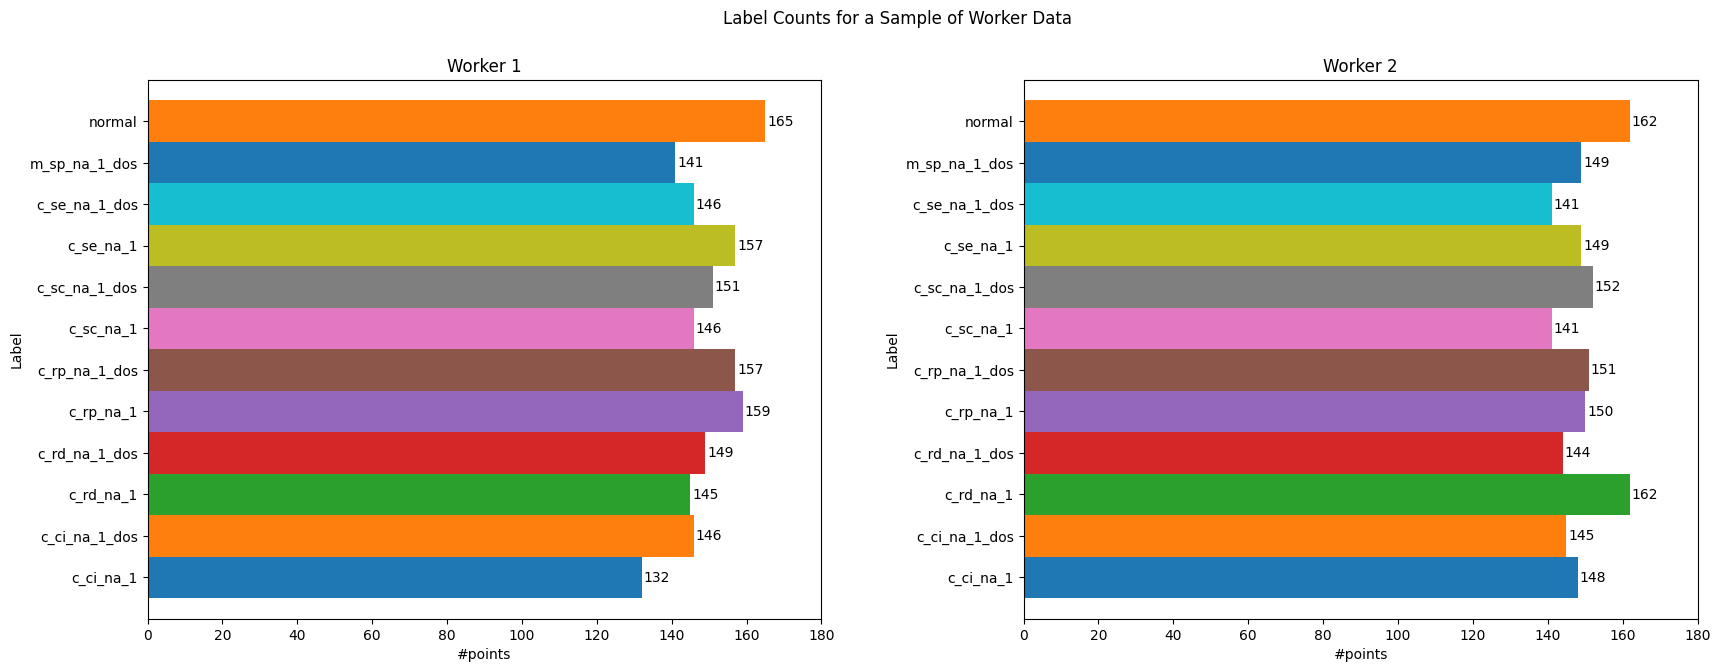

In [19]:
# Number of examples per layer for a sample of clients
fig = plt.figure(figsize=(20, 7))
fig.suptitle('Label Counts for a Sample of Worker Data')
fig.tight_layout()

for i in range(n_workers):
    m = 0
    plot_data = collections.defaultdict(list)
    sample = client_data[i]
    for label in sample['y']:
        # Append counts individually per label to make plots
        # more colorful instead of one color per plot.
        plot_data[label].append(label)
        m = max(m, len(plot_data[label]))
    
    n_cols = n_workers if n_workers < 5 else 5
    xlim = [0, m+(20-m%20)]
    ylim = [min(unique_codes)-1, max(unique_codes)+1]
    yticks = list(range(min(unique_codes), max(unique_codes)+1))
    yticks_labels = [mapping[k] for k in range(0, max(unique_codes)+1)]
    
    plt.subplot(int(n_workers / 5)+1, n_cols, i+1)
    plt.subplots_adjust(wspace=0.3)
    plt.title('Worker {}'.format(i+1))
    plt.xlabel('#points')
    plt.xlim(xlim)
    plt.ylabel('Label')
    plt.ylim(ylim)
    plt.yticks(yticks, labels=yticks_labels)
    
    # plot values on top of bars
    for key in plot_data:
        if len(plot_data[key]) > 0:
            plt.text(len(plot_data[key])+4, int(key)-0.1, str(len(plot_data[key])), ha='center')
    
    for j in range(min(unique_codes),max(unique_codes)+1):
        plt.hist(
            plot_data[j],
            density=False,
            bins=[k-0.5 for k in range(min(unique_codes),max(unique_codes)+2)],
            orientation='horizontal'
        )